# Assignment 3

This assignment covers Harris corner detector and RANSAC.

In [1]:
from __future__ import print_function

#Setup

# The Random module might be used for pseudo-random number generators
import random 

# Numpy plays important role in scientific computing with Python, especially for coding vision algorithms. 
# This package will be one of our most used libraries in this class. Make sure you spend enough time for practicing it.
import numpy as np

# This module is used to measure the execution time of code sections  
from time import time

#This module is used to process image in various formats
from skimage import filters
from skimage.feature import corner_peaks
from skimage.io import imread

#Imports all the methods in the file stitching.py
from stitching import *

#Matplotlib is a useful plotting library for python 
import matplotlib.pyplot as plt

# This code is to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (25.0, 20.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

## Introduction: Panorama Stitching
Panorama stitching is an early success of computer vision. Matthew Brown and David G. Lowe published a famous [panoramic image stitching paper](http://matthewalunbrown.com/papers/ijcv2007.pdf) in 2007. Since then, automatic panorama stitching technology has been widely adopted in many applications such as Google Street View, panorama photos on smartphones,
and stitching software such as Photosynth and AutoStitch.

In this assignment, we will detect and match keypoints from two images to build a single panoramic image. This will involve several tasks:
1. Use Harris corner detector to find keypoints.
2. Build a very simple descriptor to describe each point in an image. <br>
   Compare two sets of descriptors coming from two different images and find matching keypoints.
3. Given a list of matching keypoints, use least-squares method to find the affine transformation matrix that maps points in one image to another.
4. Use RANSAC to give a more robust estimate of affine transformation matrix. <br>
   Given the transformation matrix, use it to transform the second image and overlay it on the first image, forming a panorama.

## Part 1 Harris Corner Detector (2 points)


In this section, you are going to implement Harris corner detector for keypoint localization. Review the lecture slides on Harris corner detector (Lecture 8) to understand how it works. The Harris detection algorithm can be divide into the following steps:
1. Compute $x$ and $y$ derivatives ($I_x, I_y$) of an image
2. Compute products of derivatives ($I_x^2, I_y^2, I_{xy}$) at each pixel
3. Compute matrix $M$ at each pixel, where
$$
M = \sum_{x,y} w(x,y)
    \begin{bmatrix}
        I_{x}^2 & I_{x}I_{y} \\
        I_{x}I_{y} & I_{y}^2
    \end{bmatrix}
$$
4. Compute corner response $R=Det(M)-k(Trace(M)^2)$ at each pixel
5. Output corner response map $R(x,y)$

Step 1 is already done for you in the function **`harris_corners`** in `stitching.py`. Complete the function implementation and run the code below.

*Note: For convolution, you may use the function `scipy.ndimage.filters.convolve`, which is already imported in `stitching.py`*

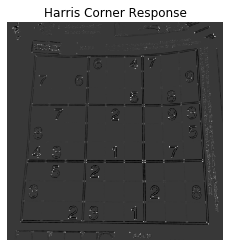

In [2]:
img = imread('sudoku.png', as_gray=True)

# Compute Harris corner response
response = harris_corners(img)

# Display corner response
plt.imshow(response)
plt.axis('off')
plt.title('Harris Corner Response')
plt.show()

Once you implement the Harris detector correctly, you will be able to see small bright blobs around the corners of the sudoku grids and letters in the output corner response image. The function `corner_peaks` from `skimage.feature` performs non-maximum suppression to take local maxima of the response map and localize keypoints.

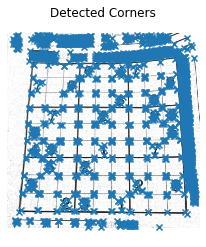

In [3]:
# Perform non-maximum suppression in response map
# and output corner coordiantes
corners = corner_peaks(response, threshold_rel=0.01)

# Display detected corners
plt.imshow(img)
plt.scatter(corners[:,1], corners[:,0], marker='x')
plt.axis('off')
plt.title('Detected Corners')
plt.show()

## Part 2 Describing and Matching Keypoints (1 point)

We are now able to localize keypoints in two images by running the Harris corner detector independently on them. Next question is, how do we determine which pair of keypoints come from corresponding locations in those two images? In order to *match* the detected keypoints, we must come up with a way to *describe* the keypoints based on their local appearance. Generally, each region around detected keypoint locations is converted into a fixed-size vectors called *descriptors*.

### Part 2.1 Creating Descriptors (0.5 point)

In this section, you are going to implement a **`simple_descriptor`**; each keypoint is described by normalized intensity in a small patch around it. Specifically, given an image patch with size $h \times w $ around a keypoint, a feature vector $f$ for the simple descriptor is computed as following:
$$
f = [\frac{x_1-\bar{m}}{\sigma}, \frac{x_2-\bar{m}}{\sigma},...,\frac{x_N-\bar{m}}{\sigma}]
$$
where, $N = h \times w$;   $\bar{m}$ and $\sigma$ are mean and standard deviation of pixel values $x_i$'s, respectively.

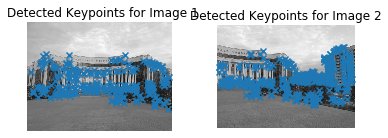

In [4]:
img1 = imread('NU1.jpg', as_gray=True)
img2 = imread('NU2.jpg', as_gray=True)

# Detect keypoints in two images
keypoints1 = corner_peaks(harris_corners(img1, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)
keypoints2 = corner_peaks(harris_corners(img2, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)

# Display detected keypoints
plt.subplot(1,2,1)
plt.imshow(img1)
plt.scatter(keypoints1[:,1], keypoints1[:,0], marker='x')
plt.axis('off')
plt.title('Detected Keypoints for Image 1')

plt.subplot(1,2,2)
plt.imshow(img2)
plt.scatter(keypoints2[:,1], keypoints2[:,0], marker='x')
plt.axis('off')
plt.title('Detected Keypoints for Image 2')
plt.show()

### Part 2.2 Matching Descriptors (0.5 point)
Then, implement **`match_descriptors`** function to find good matches in two sets of descriptors. First, calculate Euclidean distance between all pairs of descriptors from image 1 and image 2. Then use this to determine if there is a good match: if the distance to the closest vector is significantly (by a factor which is given) smaller than the distance to the second-closest, we call it a match. The output of the function is an array where each row holds the indices of one pair of matching descriptors.

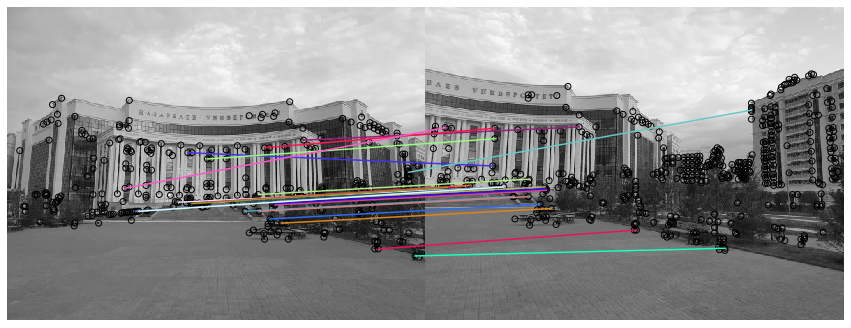

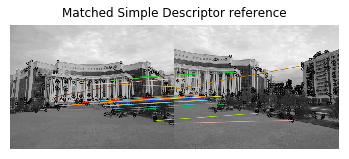

In [5]:
from utils import plot_matches

patch_size = 5

# Extract features from the corners
desc1 = describe_keypoints(img1, keypoints1,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)
desc2 = describe_keypoints(img2, keypoints2,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)

# Match descriptors in image1 to those in image2
matches = match_descriptors(desc1, desc2, 0.7)

# Plot matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
ax.axis('off')
plot_matches(ax, img1, img2, keypoints1, keypoints2, matches)
plt.show()

plt.imshow(imread('reference_simple_descriptor_matching.png'))
plt.axis('off')
plt.title('Matched Simple Descriptor reference')
plt.show()

## Part 3 Transformation Estimation (0.5 point)

We now have a list of matched keypoints across the two images. We will use this to find a transformation matrix that maps points in the second image to the corresponding coordinates in the first image. In other words, if the point $p_1 = [y_1,x_1]$ in image 1 matches with $p_2=[y_2, x_2]$ in image 2, we need to find an affine transformation matrix $H$ such that

$$
\tilde{p_2}H = \tilde{p_1},
$$

where $\tilde{p_1}$ and $\tilde{p_2}$ are homogenous coordinates (review lecture 2) of $p_1$ and $p_2$.

Note that it may be impossible to find the transformation $H$ that maps every point in image 2 exactly to the corresponding point in image 1. However, we can estimate the transformation matrix with least squares. Given $N$ matched keypoint pairs, let $X_1$ and $X_2$ be $N \times 3$ matrices whose rows are homogenous coordinates of corresponding keypoints in image 1 and image 2 respectively. Then, we can estimate $H$ by solving the least squares problem,

$$
X_2 H = X_1
$$

Implement **`fit_affine_matrix`** in `stitching.py`

*-Hint: read the [documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html) about np.linalg.lstsq*

In [6]:
# Sanity check for fit_affine_matrix

# Test inputs
a = np.array([[0.5, 0.1], [0.4, 0.2], [0.8, 0.2]])
b = np.array([[0.3, -0.2], [-0.4, -0.9], [0.1, 0.1]])

H = fit_affine_matrix(b, a)

# Target output
sol = np.array(
    [[1.25, 2.5, 0.0],
     [-5.75, -4.5, 0.0],
     [0.25, -1.0, 1.0]]
)

error = np.sum((H - sol) ** 2)

if error < 1e-20:
    print('Implementation correct!')
else:
    print('There is something wrong.')

Implementation correct!


After checking that your `fit_affine_matrix function` is running correctly, run the following code to apply it to images.
Images will be warped and image 2 will be mapped to image 1. Then, the two images are merged to get a panorama. Your panorama may NOT look good at this point, but we will later use other technique to get a better result.

Output shape: [450 783]
Offset: [0. 0.]


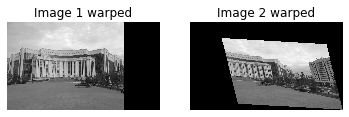

In [7]:
from utils import get_output_space, warp_image

# Extract matched keypoints
p1 = keypoints1[matches[:,0]]
p2 = keypoints2[matches[:,1]]

# Find affine transformation matrix H that maps p2 to p1
H = fit_affine_matrix(p1, p2)

output_shape, offset = get_output_space(img1, [img2], [H])
print("Output shape:", output_shape)
print("Offset:", offset)


# Warp images into output sapce
img1_warped = warp_image(img1, np.eye(3), output_shape, offset)
img1_mask = (img1_warped != -1) # Mask == 1 inside the image
img1_warped[~img1_mask] = 0     # Return background values to 0

img2_warped = warp_image(img2, H, output_shape, offset)
img2_mask = (img2_warped != -1) # Mask == 1 inside the image
img2_warped[~img2_mask] = 0     # Return background values to 0

# Plot warped images
plt.subplot(1,2,1)
plt.imshow(img1_warped)
plt.title('Image 1 warped')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2_warped)
plt.title('Image 2 warped')
plt.axis('off')

plt.show()

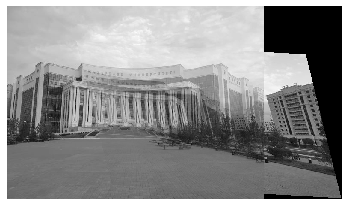

In [8]:
merged = img1_warped + img2_warped

# Track the overlap by adding the masks together
overlap = (img1_mask * 1.0 +  # Multiply by 1.0 for bool -> float conversion
           img2_mask)

# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged / np.maximum(overlap, 1)
plt.imshow(normalized)
plt.axis('off')
plt.show()

## Part 4 RANSAC (1.5 points)
Rather than directly feeding all our keypoint matches into ``fit_affine_matrix`` function, we can instead use RANSAC ("RANdom SAmple Consensus") to select only "inliers" to use to compute the transformation matrix.

The steps of RANSAC are:
    1. Select random set of matches
    2. Compute affine transformation matrix
    3. Find inliers using the given threshold
    4. Repeat and keep the largest set of inliers
    5. Re-compute least-squares estimate on all of the inliers

Implement **`ransac`** in `stitching.py`, run through the following code to get a panorama. You can see the difference from the result we get without RANSAC.

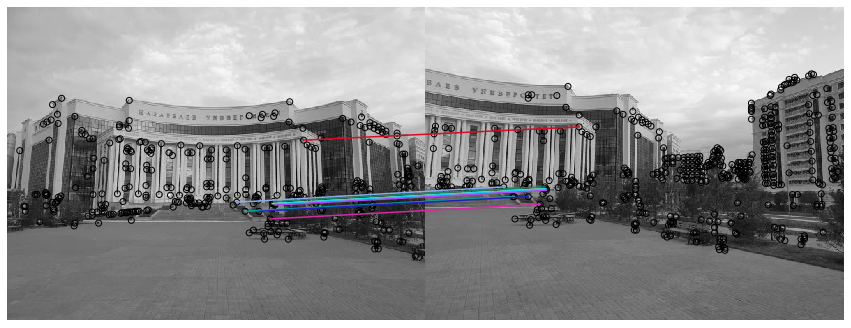

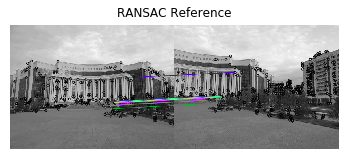

In [15]:
H, robust_matches = ransac(keypoints1, keypoints2, matches, threshold=1)

# Visualize robust matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
plot_matches(ax, img1, img2, keypoints1, keypoints2, robust_matches)
plt.axis('off')
plt.show()

plt.imshow(imread('reference_simple_descriptor_RANSACmatching.png'))
plt.axis('off')
plt.title('RANSAC Reference')
plt.show()

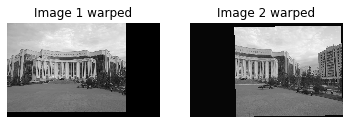

In [16]:
output_shape, offset = get_output_space(img1, [img2], [H])

# Warp images into output sapce
img1_warped = warp_image(img1, np.eye(3), output_shape, offset)
img1_mask = (img1_warped != -1) # Mask == 1 inside the image
img1_warped[~img1_mask] = 0     # Return background values to 0

img2_warped = warp_image(img2, H, output_shape, offset)
img2_mask = (img2_warped != -1) # Mask == 1 inside the image
img2_warped[~img2_mask] = 0     # Return background values to 0

# Plot warped images
plt.subplot(1,2,1)
plt.imshow(img1_warped)
plt.title('Image 1 warped')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2_warped)
plt.title('Image 2 warped')
plt.axis('off')

plt.show()

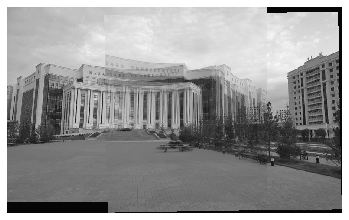

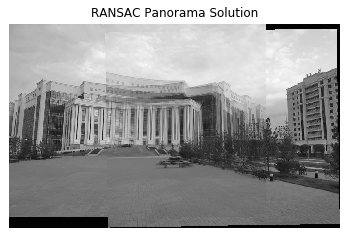

In [17]:
merged = img1_warped + img2_warped

# Track the overlap by adding the masks together
overlap = (img1_mask * 1.0 +  # Multiply by 1.0 for bool -> float conversion
           img2_mask)

# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged / np.maximum(overlap, 1)
plt.imshow(normalized)
plt.axis('off')
plt.show()

plt.imshow(imread('reference_RANSAC_panorama.png'))
plt.axis('off')
plt.title('RANSAC Panorama Solution')
plt.show()

Although the result is imporved, you will notice the blurry regions and unpleasant lines in the final panoramic image. It should be fine within the scope of this assignment because we use a very simple descriptor (not SIFT or HOG) and do not consider other steps to refine or smooth out these artifiacts from the panorama. You are encouraged to further improve the result by yourself. For example, you might try to use more advance descriptors and better image mergeing technique. Note that 